
# 주제 : 딥러닝으로 Seq2Seq 계산기 만들기
--------------
## 실습 가이드
    1. 데이터를 다운로드하여 Colab에 불러옵니다.
    2. 필요한 라이브러리는 모두 코드로 작성되어 있습니다.
    3. 코드는 위에서부터 아래로 순서대로 실행합니다.
    4. 전체 문제 구성은 좌측 첫 번째 아이콘을 통해 확인할 수 있습니다.

## 데이터 소개
    - 이번 주제는 직접 랜덤 생성한 Dataset을 사용합니다.
    - 학습 데이터와 정답 데이터는, 각각의 아래와 같습니다.
    
    1. train_text
      23 + 13
      1 - 3
      32 + 5
      1 + 62 ...
    
    2. train_answer
      36
      -1
      37
      63 ...


    
- 데이터 출처: 없음

## 최종 목표
    - Seq2Seq 기반 모델의 이해
    - word embedding 이해
    - 시계열 데이터 학습 이해
    
  - 출제자 : 손근영 강사


In [17]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense
from keras.models import Sequential

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings 
from IPython.display import Image

warnings.filterwarnings('ignore')
%matplotlib inline

SEED = 34

## Step 1. 도입전 기본 처리

### 문제 1. 랜덤 2자리 더하기 데이터와 정답셋 생성

In [18]:
# 랜덤 2자리 더하기 데이터와 정답셋을 오만쌍 생성해주세요.

import random

def make_raw_text(count = 50000):
    train_text = []
    train_answer = []

    for _ in range(count):
        t = random.randint(0, 3) # 0 ~ 3
        if t == 0:
            a = random.randint(0, 10) # 0 ~ 10
        else:
            a = random.randint(0, 100) # 0 ~ 100

        t = random.randint(0, 3)
        if t == 0:
            b = random.randint(0, 10)
        else: 
            b = random.randint(0, 100)

        if random.randint(0, 2) == 0:
            train = f'{a} + {b}'
            answer = f'{a + b}'
        else:
            train = f'{a} - {b}'
            answer = f'{a - b}'


        train_text.append(train)
        train_answer.append(answer)

    return train_text, train_answer

train_text, train_answer = make_raw_text()

        


In [19]:
print(len(train_text), len(train_answer))

for i in range(20):
    print(f'{train_text[i]} : {train_answer[i]}')

50000 50000
25 - 18 : 7
80 + 29 : 109
15 - 4 : 11
68 + 10 : 78
22 - 3 : 19
9 - 41 : -32
93 - 60 : 33
21 + 74 : 95
45 - 43 : 2
31 - 22 : 9
76 - 76 : 0
82 - 8 : 74
8 + 38 : 46
98 - 81 : 17
48 - 2 : 46
28 + 61 : 89
36 - 36 : 0
10 + 72 : 82
73 - 92 : -19
66 - 79 : -13


## Step 2. 전처리

### 문제 2. train_text, train_anser에서 나오는 모든 token을 map<token, id>형태로 변경

In [20]:
# train_text, train_anser에서 나오는 모든 token을 map<token, id>형태로 변경하세요. 
# (단, + -> 10, - -> 11, PAD -> 12, EOS -> 13)

vocab = {str(i): i for i in range(10)} # dictionary 
print(vocab)

vocab.update({'+':10, '-':11, 'PAD':12, 'EOS':13})

print(vocab.keys())
print(vocab.items())
print(vocab.get('+'))

vocab

{'0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, '9': 9}
dict_keys(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '+', '-', 'PAD', 'EOS'])
dict_items([('0', 0), ('1', 1), ('2', 2), ('3', 3), ('4', 4), ('5', 5), ('6', 6), ('7', 7), ('8', 8), ('9', 9), ('+', 10), ('-', 11), ('PAD', 12), ('EOS', 13)])
10


{'0': 0,
 '1': 1,
 '2': 2,
 '3': 3,
 '4': 4,
 '5': 5,
 '6': 6,
 '7': 7,
 '8': 8,
 '9': 9,
 '+': 10,
 '-': 11,
 'PAD': 12,
 'EOS': 13}

### 문제 3. vacab의 역형태인 map<id, token> 형태도 생성

In [21]:
# vocab의 역형태인 <id, token>을 생성하세요.

inverted_vocab = {value: key for key, value in vocab.items()}
inverted_vocab

{0: '0',
 1: '1',
 2: '2',
 3: '3',
 4: '4',
 5: '5',
 6: '6',
 7: '7',
 8: '8',
 9: '9',
 10: '+',
 11: '-',
 12: 'PAD',
 13: 'EOS'}

### 문제 4. train_text와 train_anser를 BoW(Bag of Words) 형태로 변경

Bag of Words란 단어들의 순서는 전혀 고려하지 않고, 단어들의 출현 빈도에만 집중하는 텍스트 데이의 수치화 표현방법

(단어들의 가방) 단어의 순서는 중요하지 않음

In [22]:
# train_text와 train_anser를 BoW 형태로 변경하세요.

def plain2bow(text, vocab):
    return np.array([vocab[char] for word in text.split() for char in word] + [vocab['EOS']])
    
    for word in text.split():
        for ch in word:
            result.append(vocab[ch])
    result.append(vocab['EOS'])

"""
train_text                        
'50 + 9'
'11 + 31'

vocab
{'0': 0,
 '1': 1,
 '2': 2,
 '3': 3,
 '4': 4,
 '5': 5,
 '6': 6,
 '7': 7,
 '8': 8,
 '9': 9,
 '+': 10,
 '-': 11,
 'PAD': 12,
 'EOS': 13}
"""

train_bow_text = [plain2bow(text, vocab) for text in train_text]
train_bow_answer = [plain2bow(text, vocab) for text in train_answer]

print(train_text[0]) # '50 + 9'
print(train_bow_text[0]) # [5, 0, 10, 9, 13]
 
print(train_answer[0]) #'59'
print(train_bow_answer[0]) # [5, 9, 13]


25 - 18
[ 2  5 11  1  8 13]
7
[ 7 13]


In [23]:
text = '50 + 9'
for word in text.split():
    print(f'word: {word}')
    for ch in word:
        print(f'ch: {ch}')

word: 50
ch: 5
ch: 0
word: +
ch: +
word: 9
ch: 9


### 문제 5. train_bow_text와 train_bow_answer에 padding을 추가하여 완전한 np.array로 변경하세요.

In [24]:
# train_bow_text와 train_bow_answer에 padding을 추가하여 완전한 np.array로 변경하세요.

"""
tf.keras.preprocessing.sequence.pad_sequences 
    - 주어진 시퀀스들의 길이를 동일하게 맞추기 위해 패딩 추가
    - 기본적으로 각 시퀀스의 앞쪽에 패딩이 추가되며 값은 0
    - 반환 값은 np.array

value = vocab['PAD] 
    - value 인자를 사용해 패딩 시 사용할 값을 지정할 수 있다. 
      여기서는 vocab 딕셔너리의 'PAD'에 해당하는 값(13)을 패딩값으로 사용

padding = 'post' 
    - 패딩을 추가하는 위치를 지정할 수 있다.
    - 기본값은 'pre'로서 시퀀스의 앞쪽에 패딩이 추가된다. 
    - 'post'를 지정하면 시퀀스의 뒷쪽에 패딩이 추가된다.
"""


train_bow_text = tf.keras.preprocessing.sequence.pad_sequences(train_bow_text, value = vocab['PAD'])



train_bow_answer = tf.keras.preprocessing.sequence.pad_sequences(train_bow_answer, 
                                                                 padding='post', 
                                                                 value = vocab['PAD'])

In [25]:
print(train_bow_text.shape, train_bow_answer.shape)
print(train_bow_text[11])
print(train_bow_answer[11])

(50000, 8) (50000, 5)
[12 12 12  8  2 11  8 13]
[ 7  4 13 12 12]


### 문제 6. train_bow_text를 train_data_bow, test_data_bow로 (98%, 2%의 개수) 분리해보세요.

In [26]:
# train_bow_text를 train_bows, test_bows로 (98%, 2%의 개수) 분리해보세요.

def getSplit(data, rate):
    return int(len(data) * rate)

upper_bound = getSplit(train_bow_text, 0.98)

train_data_bow = train_bow_text[:upper_bound]
train_answer_bow = train_bow_answer[:upper_bound]

test_data_bow = train_bow_text[upper_bound:]
test_answer_bow = train_bow_answer[upper_bound:]

print(train_data_bow.shape, train_answer_bow.shape)
print(test_data_bow.shape, test_answer_bow.shape)

(49000, 8) (49000, 5)
(1000, 8) (1000, 5)


## Step 3. 시각화 방법

### 문제 7. train_data_bow에서 등장하는 token의 분포를 출력해보세요.

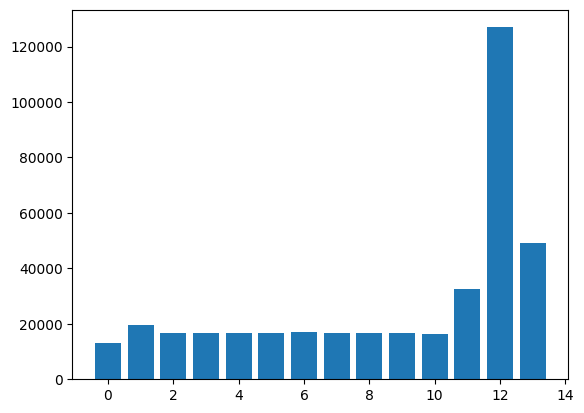

In [27]:
#  train_data_bow에서 등장하는 token의 분포를 출력해보세요.

"""
np.unique
    - 입력 배열에서 중복을 제거한 후, 유효한 값들을 정렬된 형태로 반환 

return_counts = True
    - 유일 한 값의 빈도수도 함께 반환
"""

digits, frequency = np.unique(train_data_bow, return_counts=True)

plt.bar(digits, frequency)
plt.show()

### 문제 8. train_answer_bow에서 등장하는 token의 분포를 출력해보세요.

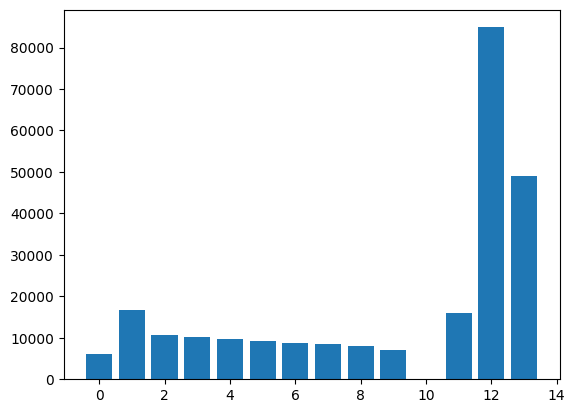

In [28]:
#  train_answer_bow에서 등장하는 token의 분포를 출력해보세요.

digits, frequency = np.unique(train_answer_bow, return_counts=True)

plt.bar(digits, frequency)
plt.show()

## Step 4. Seq2Seq용 입출력 보정

### 문제 9. train/test_answer_bow를 한쪽씩 당겨서 decoder에 주입시킬 데이터를 생성해보세요.

In [29]:
train_answer_bow.shape[0]

a = np.ones(shape=(train_answer_bow.shape[0], 1))
print(a.shape)

(49000, 1)


In [30]:
print(train_answer_bow[:5])

[[ 7 13 12 12 12]
 [ 1  0  9 13 12]
 [ 1  1 13 12 12]
 [ 7  8 13 12 12]
 [ 1  9 13 12 12]]


In [31]:
# train/test_answer_bow를 한쪽씩 당겨서 decoder에 주입시킬 데이터를 생성해보세요.

# 열다마 PAD를 맨 앞에 추가하고 열마다 맨 뒤 쪽에 있는 PAD 제거
train_shift_answer_bow = np.concatenate([np.ones(shape=(train_answer_bow.shape[0], 1)) * vocab['PAD'], train_answer_bow[...,:-1]], axis = 1)
test_shift_answer_bow = np.concatenate([np.ones(shape=(test_answer_bow.shape[0], 1)) * vocab['PAD'], test_answer_bow[...,:-1]], axis = 1)
print(train_shift_answer_bow[:5])

[[12.  7. 13. 12. 12.]
 [12.  1.  0.  9. 13.]
 [12.  1.  1. 13. 12.]
 [12.  7.  8. 13. 12.]
 [12.  1.  9. 13. 12.]]


### 문제 10. 정답으로 처리될 train/test_answer_bow를 onehot 인코딩으로 바꾸기

In [32]:
print(train_answer_bow[:5])
print(len(vocab))

[[ 7 13 12 12 12]
 [ 1  0  9 13 12]
 [ 1  1 13 12 12]
 [ 7  8 13 12 12]
 [ 1  9 13 12 12]]
14


In [33]:
# train/test_anser_bow를 onehot으로 바꾸는 코드를 작성하세요

train_answer_onehot = tf.keras.utils.to_categorical(train_answer_bow, len(vocab))
test_answer_onehot = tf.keras.utils.to_categorical(test_answer_bow, len(vocab))

print(train_answer_onehot.shape, test_answer_onehot.shape)
print(train_answer_bow[0])
print(train_answer_onehot[0])

(49000, 5, 14) (1000, 5, 14)
[ 7 13 12 12 12]
[[0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]


### 문제 11. data_bow, anser_bow, shift_answer_bow, onehot를 1개씩 출력해보세요.

In [34]:
# data_bow, shift_answer_bow, onehot, answer_bow등을 1개씩 출력해보세요

print(train_data_bow[0], train_data_bow.shape)
print(train_answer_bow[0], train_answer_bow.shape)
print(train_shift_answer_bow[0], train_shift_answer_bow.shape)
print(train_answer_onehot[0], train_answer_onehot.shape)

train_answer_onehot[0][1].argmax()

[12 12  2  5 11  1  8 13] (49000, 8)
[ 7 13 12 12 12] (49000, 5)
[12.  7. 13. 12. 12.] (49000, 5)
[[0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]] (49000, 5, 14)


13

### 문제 12. onehot를 readable하게 바꿔주는 함수를 작성해보세요.

"".join()은 문자열을 연결하는데 사용되는 메서드로 이 메서드는 주어진 순회 가능한(terable) 항목들을 하나의 문자열로 합쳐준다

``` python
separator.join(iterable)
```

<br/>

ex)

``` python
words = ["Hello", "World"]
result = " ".join(words)
print(result)  # Hello World

words = ["apple", "banana", "cherry"]
result = "-".join(words)
print(result) # apple - banana - cherry

words = ["a", "b", "c"]
result = "".join(words)
print(result) # abc
```
---


In [35]:
# onehot을 readable하게 바꿔주는 함수를 작성해보세요. (단, EOS는 .으로 PAD는 공백으로 전환)

"""
inverted_vocab
{0: '0',
 1: '1',
 2: '2',
 3: '3',
 4: '4',
 5: '5',
 6: '6',
 7: '7',
 8: '8',
 9: '9',
 10: '+',
 11: '-',
 12: 'PAD',
 13: 'EOS'}

"""
def onehot2text(onehot):
    return "".join(inverted_vocab[step.argmax()] for step in onehot).replace('EOS', '.').replace('PAD', '')

print(train_answer_onehot[0])
print(train_text[0])
print(onehot2text(train_answer_onehot[0]))


[[0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]
25 - 18
7.


### 문제 13. bow를 readable하게 바꿔주는 함수를 작성해보세요.

In [36]:
# bow를 readable하게 바꿔주는 함수를 작성해보세요. (단, EOS는 .으로 PAD는 _으로 전환)

def bow2text(bow):
    return "".join(inverted_vocab[step] for step in bow).replace('EOS', '.').replace('PAD', '')

print(train_data_bow[0])
print(bow2text(train_data_bow[0]))

print(train_answer_bow[0])
print(bow2text(train_answer_bow[0]))

print(train_shift_answer_bow[0])
print(bow2text(train_shift_answer_bow[0]))

print(train_data_bow.shape)
print(train_answer_bow.shape)
print(train_shift_answer_bow.shape)

[12 12  2  5 11  1  8 13]
25-18.
[ 7 13 12 12 12]
7.
[12.  7. 13. 12. 12.]
7.
(49000, 8)
(49000, 5)
(49000, 5)


## Step 5. Seq2Seq 모델링

### 문제 14. Seq2Seq 모델 구축

## Embedding 

- 임베딩 행렬의 구조: 임베딩 행렬의 각 행은 vocab에 있는 각 단어 또는 문자에 해당한다. 예를 들어 vocab에 '0', '1', ...'EOS'가 있으면 임베딩 행렬의 첫번째 행은 '0', 두번째 행은 '1'에 대응되는 output_dim 길이의 벡터를 가진다.

- 벡터의 의미: 초기의 임베딩 행렬의 값들은 무작위로 설정된다. 그러나 훈련 과정중에 모델은 이 벡터들을 조정하며 각 단어 또는 문자가 주어진 작업에 대해 가장 유익한 방식으로 표현되도록 한다. 

- 의미적 유사성: 훈련이 진행됨에 따라, 의미적으로 비슷한 단어나 문자는 임베딩 공간에서 유사한 벡터를 찾게된다. 즉, 그들의 벡터 표현이 서로 유사해진다. 

- 차원의 크기 output_dim = 5는 임베딩 벡터의 차원(열의 길이)이 5라는 것을 의미한다.(열의 길이) 
이것은 각 단어 또는 문자를 5개의 실수 값으로 표현한다는 것을 의미한다. 이 5차원 벡터는 해당 단어 또는 문자의 의미와 관련된 정보를 포함하게 된다. 

<br/>

ex) 
'킹' 이라는 단어의 임베딩 벡터가 [1, 2, 3]이라고 가정 

'여왕' 이라는 단어의 임베딩 벡터가 [1.1, 2.1, 2.9] 라고 가정 

'자동차' 라는 단어의 임베딩 벡터가 [5, 5, 5]라고 가정

위의 예에서 '킹'과 '여왕'의 벡터는 임베딩 공간에서 서로 가깝다. 이 두 벡터의 거리(유클리디안 거리)가 작기 때문, 반면 '킹'과 '자동차' 사이의 거리는 더 멀다

<br/>

즉 임베딩은 의미상 비슷한 단어나 항목을 공간에서 서로 가까운 위치로 맵핑하려고 하며 이는 임베딩 레이어가 데이터에서 단어나 항목 간의 관계를 학습하는동안 자연스럽게 발생한다.

<br/>


``` python
embedding_matrix:
[[0.1, 0.2, 0.3],
 [0.4, 0.5, 0.6],
 [0.7, 0.8, 0.9]
  ...
]

input_data: [2, 0, 1]

output:
[[0.7, 0.8, 0.9], # embedding matrix 의 2번째 행
 [0.1, 0.2, 0.3], # embedding matrix 의 0번째 행
 [0.4, 0.5, 0.6]] # embedding matrix 의 1번째 행
```

In [37]:
# seq2seq 모델을 구축하고 학습모델, encoder, decoder를 획득하세요

from keras.layers import Input, Embedding, GRU
from keras.models import Model

def seq2seq():
    encoder_input = Input(shape = (8, ))

    # encoder
    embedding = Embedding(len(vocab), output_dim=5) # (14, 5)
    x = embedding(encoder_input) # x = (8, 5)
    context_vector = GRU(units = 16)(x) # z = context vector 

    # decoder
    decoder_input = Input(shape = (5, ))
    y = embedding(decoder_input) # y = (5, 5)
    gru = GRU(units = 16, return_sequences=True)
    """
    return_sequences=True 에 대한 설명 

    return_sequences=True는 Keras의 순환층(예: LSTM, GRU)에서 사용되는 매개변수로 이 매개변수의 값에 따라 순환층이 반환하는 출력의 형태가 달라진다.

    1. return_sequences=True 
        - 순환층은 각 타임스텝에 대한 히든 상태를 반환한다.
        - 만약 입력 시퀀스의 길이가 t라면 순환층의 출력은 (batch, t, hidden_units)의 헝태를 가진다. 즉 각 입력 시퀀스 타임스텝에 대한 출력이 순차적으로 반환
        - 주로 시퀀스 출력이 필요한 경우나 다른 순환층과 연결될 때 사용된다.

        - Seq2Seq, 다층 순환 신경망(Stacked RNN), 양방향 순환 신경망(Bidirectional RNN), Attention Mechanism, etc...
        

    2. return_sequences=False(기본값) 
        - 순환층은 마지막 타임스텝에 대한 히든 상태만 반환한다. 
        - 출력의 형태는 (batch, hidden_units)
        - 주로 전체 시퀀스 정보를 요약하고자 할 때나, 다음층이 순환층이 아닐 때 사용한다.

    용어
    - 타임스텝 (time step)
        시퀀스 데이터에서의 각 요소나 시점을 의미
        시퀀스 데이터를 생각할 때, 각 데이터 포인트가 어떤 순서에 따라 발생하는 경우, 그 순서의 각 위치를 타임스텝이라고 한다.

        ex)
        문장: "안녕하세요"

        타임스텝 1: "안" 
        타임스텝 2: "녕"
        타임스텝 3: "하"
        타임스텝 4: "세"
        타임스텝 5: "요"
    """

    y = gru(y, initial_state=context_vector) # encoder에서 생성된 context vector를 decoder로 전달
    """
    initial_state=z 에 대한 설명


    z는 문맥 벡터(context vector)라고 불리며 이 context vector는 인코더의 마지막 히든 상태이다.

    seq2seq 모델에서 인코더의 주요 먹적은 입력 시퀀스를 하나의 고정된 크기의 벡터, 즉 context vector로 압축하는 것이다. 
    이 벡터는 입력 시퀀스의 전체 정보를 포함하게 된다.

    디코더는 이 context vector를 사용해서 원하는 출력 시퀀스를 생성한다. 디코더의 초기 상태로 인코더의 context vector를 설정함으로써, 인코더에서 추출한 정보가
    디코더로 전달된다. 이렇게 해서 디코더는 입력 시퀀스에 기반한 적절한 출력 시퀀스를 생성할 수 있다.

    간단한 예로, 번역모델의 인코더는 영어 문장을 문맥 벡터로 압축하고, 디코더는 그 문맥 벡터를 사용해 해당 영어 문장의 한국어 번역을 생성한다. 
    여기서 context vector는 영어 문장의 전체적인 의미를 포함하며, 디코더는 그 정보를 활용해서 한국어로 번역된 문장을 생성한다.

    즉 seq2seq 모델에서 인코더의 출력 (context vector)을 디코더의 초기상태로 설정해야 인코더에서 얻은 정보를 디코더로 전달해 줄 수 있다.
    initial_state = z를 통해 디코더의 초기 상태로 설정하게 되면, 디코더는 해당 문맥 벡터에 포함된 정보를 기반으로 출력 시퀀스를 생성하기 시작한다
    """

    softmax = Dense(units = len(vocab), activation='softmax')
    y = softmax(y)
    
    model = Model([encoder_input, decoder_input], y)
    model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

    
    encoder = Model(encoder_input, context_vector)




    """ 디코더의 각 타임스텝에서 입력될 하나의 토큰(단어나 문자 등)을 나타내는 입력 """
    next_decoder_input = Input(shape = (1, )) # 자기 자신의 출력물을 다음 네트워크가 받을 수 있도록 하기 위한 변수 (EX 'PAD')
    next_decoder_embedded = embedding(next_decoder_input) #  그 토큰을 임베딩 공간으로 변환

    decoder_initial_state = Input(shape = (16, )) # encoder의 GRU의 유닛 수(16)
    """ units = 16은 GRU레이어의 숨겨진 상태의 크기, 즉 히든 스테이트의 차원을 나타낸다.
        z는 그 결과로서, 마지막 타임 스텝에서의 GRU의 히든 스테이트, 즉 context vector가 된다.

        디코더에서 초기 상태로 사용될 inputs_z는 인코더의 context_vector z와 동일한 차원을 가져가야 한다. 
    """
    decoder_gru_output = gru(next_decoder_embedded, initial_state=decoder_initial_state)
    decoder_softmax_output = softmax(decoder_gru_output)


    """
    디코더의 입력:
    1. next_decoder_input: 이는 디코더의 다음 타임스텝에 들어갈 입력값입니다. 
       seq2seq 모델에서의 디코더는 이전 타임스텝의 출력을 현재 타임스텝의 입력으로 사용하기 때문에 이 변수가 필요합니다.
    
    2. decoder_initial_state: 이는 디코더의 GRU의 초기 상태로 사용됩니다. 
       일반적으로 seq2seq 모델에서는 인코더의 마지막 상태, 즉 context_vector가 이 초기 상태로 사용됩니다. 
       그러나 훈련된 인코더-디코더 모델을 사용하여 새로운 시퀀스를 생성할 때는 디코더의 이전 타임스텝의 상태를 이 초기 상태로 사용하게 됩니다.

    디코더의 출력:
    1. decoder_softmax_output: 이는 디코더의 GRU 출력을 softmax 활성화 함수를 통과시킨 결과입니다. 
       이 출력은 각 단어의 확률 분포를 나타내므로 가장 확률이 높은 단어를 선택하여 다음 타임스텝의 입력으로 사용할 수 있습니다.

    2. decoder_gru_output: 이는 디코더의 GRU 층의 직접적인 출력입니다. 
       이 값은 다음 타임스텝의 초기 상태로 사용될 수 있습니다.
       요약하면, 디코더는 next_decoder_input과 decoder_initial_state를 입력으로 받아, 그에 해당하는 softmax 확률 분포와 다음 상태를 출력합니다.
    """
    decoder = Model([next_decoder_input, decoder_initial_state], [decoder_softmax_output, decoder_gru_output])
    

    return model, encoder, decoder

### 문제 15. 학습 모델을 생성하고 summary를 출력하세요. 

In [38]:
# 학습 모델을 생성하고 summary를 출력하세요.

model, encoder, decoder = seq2seq()
print(model.summary())
print(encoder.summary())
print(decoder.summary())

2023-10-26 22:03:52.431195: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2023-10-26 22:03:52.431221: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2023-10-26 22:03:52.431226: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
2023-10-26 22:03:52.431256: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-10-26 22:03:52.431271: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 5)]                  0         []                            
                                                                                                  
 input_1 (InputLayer)        [(None, 8)]                  0         []                            
                                                                                                  
 embedding (Embedding)       multiple                     70        ['input_1[0][0]',             
                                                                     'input_2[0][0]']             
                                                                                                  
 gru (GRU)                   (None, 16)                   1104      ['embedding[0][0]']       

### 문제 16. encoder, decoder에 대한 summary를 출력하세요.

In [39]:
model, encoder, decoder = seq2seq()
print(model.summary())
print(encoder.summary())
print(decoder.summary())

print(f'(문제) train_data_bow\n {train_data_bow[0]}')
print(f'(문제) train_shift_answer_bow\n {train_shift_answer_bow[0]}')
print(f'(정답) train_answer_onehot\n {train_answer_onehot[0]}')

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 5)]                  0         []                            
                                                                                                  
 input_5 (InputLayer)        [(None, 8)]                  0         []                            
                                                                                                  
 embedding_1 (Embedding)     multiple                     70        ['input_5[0][0]',             
                                                                     'input_6[0][0]']             
                                                                                                  
 gru_2 (GRU)                 (None, 16)                   1104      ['embedding_1[0][0]']   

(문제) train_data_bow

 [12 12 12  5  0 10  9 13]

(문제) train_shift_answer_bow

 [12.  5.  9. 13. 12.]

(정답) train_answer_onehot

 [[0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]

 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]

 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]

 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]


---

### 1. 인코더:

**입력**: `train_data_bow`: [12 12 12  5  0 10  9 13]
이 입력은 '50 + 9'를 나타냅니다. 그러나 이 숫자 시퀀스의 앞부분에는 'PAD'(값이 12인 토큰)가 3개 있습니다. 이는 모든 입력 시퀀스의 길이를 동일하게 하기 위한 패딩입니다.

1. `embedding`: 이 숫자 시퀀스는 임베딩 레이어를 통해 각 숫자를 해당하는 밀집 벡터로 변환합니다.
2. `GRU`: 임베딩 레이어의 출력은 GRU 레이어에 전달됩니다. GRU는 입력 시퀀스를 순차적으로 처리하고 마지막 시간 단계의 은닉 상태를 출력합니다. 이 은닉 상태는 컨텍스트 벡터(`z`)로 간주되며, 전체 입력 시퀀스의 정보를 포함하고 있습니다.

### 2. 디코더:

**입력**: `train_shift_answer_bow`: [12.  5.  9. 13. 12.]
이 입력은 '59'를 나타내며, 'EOS' 토큰(값이 13인 토큰)으로 끝나는데, 이는 시퀀스의 끝을 나타냅니다.

1. `embedding`: 디코더의 입력 시퀀스도 임베딩 레이어를 통해 밀집 벡터로 변환됩니다.
2. `GRU`: 임베딩 레이어의 출력과 인코더의 컨텍스트 벡터(`z`)가 디코더의 GRU 레이어에 전달됩니다. 컨텍스트 벡터는 디코더의 초기 상태로 설정됩니다.
3. `softmax`: GRU의 출력은 Dense 레이어에 전달되어 각 가능한 출력 토큰에 대한 확률 분포를 생성합니다.



Seq2Seq의 핵심 아이디어는 인코더가 주어진 입력 시퀀스를 "컨텍스트 벡터"로 압축하고, 디코더가 이 컨텍스트 벡터를 사용하여 출력 시퀀스를 생성하는 것입니다.

### 디코더:

`train_shift_answer_bow`: [12.  5.  9. 13. 12.]

이는 우리가 예측하고자 하는 정답인 '59'를 나타냅니다. 여기서 중요한 점은 디코더에게 입력으로 주어지는 데이터가 실제 답안의 "이전" 토큰임을 이해하는 것입니다. 따라서, 주어진 시퀀스는 실제로 'PAD59EOS'를 나타냅니다.

### 디코더의 타임 스텝별 동작:

**1. 타임 스텝 1**:
- 입력: 'PAD' (12)
- 초기 상태: 인코더의 컨텍스트 벡터 `z`
- GRU 출력: 'PAD'에 대한 은닉 상태
- Softmax 출력: '5'의 확률이 가장 높음 (예를 들면)

**2. 타임 스텝 2**:
- 입력: '5' (학습 시에는 실제 값인 5가 주어짐)
- 초기 상태: 타임 스텝 1에서 GRU의 출력 상태
- GRU 출력: '5'에 대한 은닉 상태
- Softmax 출력: '9'의 확률이 가장 높음 (예를 들면)

**3. 타임 스텝 3**:
- 입력: '9' (학습 시에는 실제 값인 9가 주어짐)
- 초기 상태: 타임 스텝 2에서 GRU의 출력 상태
- GRU 출력: '9'에 대한 은닉 상태
- Softmax 출력: 'EOS'의 확률이 가장 높음

**4. 타임 스텝 4**:
- 입력: 'EOS' (13)
- 초기 상태: 타임 스텝 3에서 GRU의 출력 상태
- GRU 출력: 'EOS'에 대한 은닉 상태
- Softmax 출력: 'PAD'의 확률이 가장 높음

**5. 타임 스텝 5**:
- 입력: 'PAD' (12)
- 초기 상태: 타임 스텝 4에서 GRU의 출력 상태
- GRU 출력: 'PAD'에 대한 은닉 상태
- Softmax 출력: 다음 예측값

이렇게 디코더는 각 타임 스텝에서 이전 타임 스텝의 출력(또는 실제 값)과 이전 상태를 사용하여 다음 토큰을 예측합니다. 학습 중에는 실제 값이 디코더의 입력으로 제공되며, 이를 "교사 강요"(Teacher Forcing)라고 합니다. 

학습이 끝나면, 예측 시에는 디코더는 자신의 출력을 다음 타임 스텝의 입력으로 사용합니다.

### 학습:

1. 인코더는 `train_data_bow`를 입력으로 받아 컨텍스트 벡터를 생성합니다.
2. 디코더는 생성된 컨텍스트 벡터와 `train_shift_answer_bow`를 입력으로 받아 예측 시퀀스를 생성합니다.
3. 이 예측 시퀀스는 `train_answer_onehot`과 비교되어 손실이 계산됩니다.
4. 이 손실을 사용하여 모델의 가중치를 업데이트합니다.

요약하면, 인코더는 입력 시퀀스를 컨텍스트 벡터로 변환하며, 디코더는 이 컨텍스트 벡터와 자신의 입력을 사용하여 출력 시퀀스를 생성합니다. 학습 중에는 이 출력 시퀀스가 실제 타겟 시퀀스와 비교되어 모델을 업데이트합니다.

### 문제 17. 학습모델을 학습해보세요.

In [40]:
# 학습모델을 학습해보세요.

hist = model.fit(
    [train_data_bow, train_shift_answer_bow], train_answer_onehot,
    validation_data = (
        [test_data_bow, test_shift_answer_bow],
        test_answer_onehot
    ),
    verbose = 1,
    epochs = 60
)

Epoch 1/60


2023-10-26 22:03:54.620478: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-10-26 22:03:54.885811: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-10-26 22:03:54.949767: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-10-26 22:03:55.094511: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-10-26 22:03:55.188815: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1532/1532 [==============================] - ETA: 0s - loss: 1.2411 - accuracy: 0.5837

2023-10-26 22:04:29.458162: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-10-26 22:04:29.550833: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-10-26 22:04:29.593339: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1532/1532 [==============================] - 37s 23ms/step - loss: 1.2411 - accuracy: 0.5837 - val_loss: 0.9602 - val_accuracy: 0.6594
Epoch 2/60
1532/1532 [==============================] - 34s 22ms/step - loss: 0.8985 - accuracy: 0.6713 - val_loss: 0.8658 - val_accuracy: 0.6764
Epoch 3/60
1532/1532 [==============================] - 33s 22ms/step - loss: 0.8442 - accuracy: 0.6895 - val_loss: 0.8260 - val_accuracy: 0.6978
Epoch 4/60
1532/1532 [==============================] - 33s 21ms/step - loss: 0.7895 - accuracy: 0.7141 - val_loss: 0.7619 - val_accuracy: 0.7306
Epoch 5/60
1532/1532 [==============================] - 33s 21ms/step - loss: 0.7271 - accuracy: 0.7433 - val_loss: 0.7002 - val_accuracy: 0.7566
Epoch 6/60
1532/1532 [==============================] - 33s 21ms/step - loss: 0.6707 - accuracy: 0.7664 - val_loss: 0.6445 - val_accuracy: 0.7724
Epoch 7/60
1532/1532 [==============================] - 33s 22ms/step - loss: 0.6218 - accuracy: 0.7836 - val_loss: 0.6094 - val_accura

### 문제 18. 학습 진행 사항을 plt으로 출력하세요.

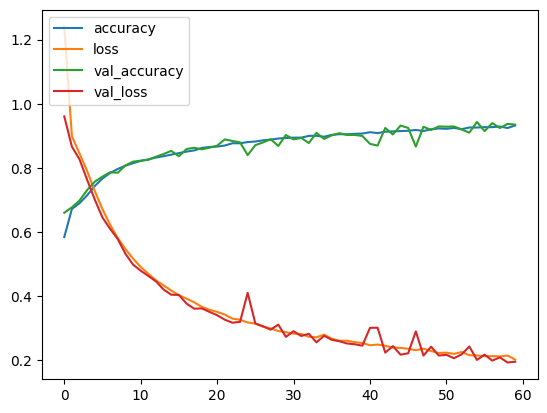

In [41]:
# hist의 accuracy와 loss를 plt의 plot을 이용하여 출력하는 코드를 작성하세요.

plt.plot(hist.history['accuracy'], label = 'accuracy')
plt.plot(hist.history['loss'], label = 'loss')
plt.plot(hist.history['val_accuracy'], label = 'val_accuracy')
plt.plot(hist.history['val_loss'], label = 'val_loss')
plt.legend(loc = 'upper left')
plt.show()

## Step 6. 모델 결과 확인

### 문제 19. plain2bow를 이용하여 encoder에 bow를 주입하고 z를 받아보세요.

In [42]:
def plain2bow(text, vocab):
    return np.array([vocab[char] for word in text.split() for char in word] + [vocab['EOS']])

In [43]:
# plain2bow를 이용하여 encoder에 bow를 주입하고 z를 받아보세요.
bow = plain2bow("11 + 11", vocab)
bow = keras.preprocessing.sequence.pad_sequences(bow[np.newaxis,:], value=vocab['PAD'], maxlen=8)
context_vector = encoder(bow)

print(bow.shape, bow)
print(context_vector)

(1, 8) [[12 12  1  1 10  1  1 13]]
tf.Tensor(
[[-0.56397927 -0.03953929  0.9995534   0.09812198  0.9999832  -0.31743038
  -0.1387286  -0.6269738  -0.3473265  -0.9988625  -0.99112797 -0.9896977
   0.9605613  -0.9241668   0.84268594  0.99998635]], shape=(1, 16), dtype=float32)


### 문제 20. z와 PAD를 이용하여 첫번째 decoder 값을 획득해보세요.

In [44]:
# z와 PAD를 이용하여 첫번째 decoder 값을 획득해보세요.

init = np.array([vocab['PAD']])
print(init)

first_pred, decoder_first_z = decoder([init, context_vector])

print(first_pred, decoder_first_z)

print(first_pred.numpy().argmax())

[12]
tf.Tensor(
[[[2.13360973e-09 1.54821619e-01 8.45018983e-01 1.54824622e-04
   4.96740915e-09 1.01301995e-10 1.97923518e-11 8.15454440e-11
   1.67745231e-08 4.54690917e-06 9.38847168e-15 5.23919574e-18
   1.10197173e-11 9.49328435e-20]]], shape=(1, 1, 14), dtype=float32) tf.Tensor(
[[[-0.99986714 -0.99964404  0.33810085 -0.7053886  -0.2710431
    0.9948965  -0.9619767   0.7557475  -0.26890483 -0.99958247
   -0.9674766  -0.99980193 -0.99446297 -0.74903244  0.9570804
    1.0000001 ]]], shape=(1, 1, 16), dtype=float32)
2


### 문제 21. first_pred에 값이 가장 큰 index를 이용하여 문자로 decoding 하세요.

In [45]:
# first_pred에 값이 가장 큰 index를 이용하여 문자로 decoding 하세요.

second_pred, decoder_second_z = decoder([np.array([first_pred.numpy().argmax()]), decoder_first_z[0]])

print(second_pred, decoder_second_z)

print(second_pred.numpy().argmax())

tf.Tensor(
[[[3.8322559e-01 5.2788037e-01 7.7921629e-02 1.0597830e-02 3.6832041e-04
   6.1465435e-06 1.5246128e-07 2.1902353e-09 5.9369447e-11 5.3625333e-13
   1.3712573e-13 9.3953389e-14 5.5824013e-16 3.7457952e-09]]], shape=(1, 1, 14), dtype=float32) tf.Tensor(
[[[-0.99986666 -0.9999177   0.86941653 -0.7601866   0.8241618
   -0.854398    0.87542474 -0.9193011  -0.23460813 -0.999997
    0.9116286  -0.9999644  -0.99999523 -0.8724707   0.88665026
    0.9997462 ]]], shape=(1, 1, 16), dtype=float32)
1


### 문제 22. first_z와 first_pred를 이용해서 second_pred를 획득하고 문자로 decoding 해보세요.

In [46]:
# irst_z와 first_pred를 이용해서 second_pred를 획득하고 문자로 decoding 해보세요.

third_pred, decoder_third_z = decoder([np.array([second_pred.numpy().argmax()]), decoder_second_z[0]])

print(third_pred.shape, decoder_third_z)

(1, 1, 14) tf.Tensor(
[[[ 0.74004686 -0.99999994 -0.3973489  -0.89279777  0.98319966
   -0.99750566 -0.88542014 -0.9848614   0.452755    0.9686606
    0.9637296  -0.96470124 -0.99999976  0.9932334   0.9999942
    0.9999991 ]]], shape=(1, 1, 16), dtype=float32)


### 문제 23. 입력 text가 주어지면 bow로 바꾼뒤 pad가 나올 때까지 문자를 decoding하는 함수를 만드세요.


In [47]:
# z와 pad가 주어지면 pad가 나올 때까지 문자를 decoding하는 함수를 만드세요.

def decoding(text):
    bow = plain2bow(text, vocab)
    bow = tf.keras.preprocessing.sequence.pad_sequences(bow[np.newaxis, :], value=vocab['PAD'], maxlen=8)

    context_vector = encoder(bow)
    word_vec = np.array([vocab['PAD']])

    res = []
    while True:
        word_vec, context_vector = decoder([word_vec, context_vector])
        word = inverted_vocab[word_vec.numpy().argmax()]

        if word in ['EOS', 'PAD']: break

        res.append(word)
        
        word_vec = np.array([word_vec.numpy().argmax()])
        context_vector = context_vector[0]

    answer = ''.join(res)
    print(f'{text} = {answer}')

    return answer
    

### 문제 24. decoding으로 몇가지 산술 연산을 테스트해보세요.

In [48]:
# decoding으로 몇가지 산술 연산을 테스트해보세요

decoding("12 + 12")

12 + 12 = 24


'24'

### 문제 25. 모델을 평가해보세요.

In [49]:
# 모델을 평가해보세요.

model.evaluate([test_data_bow, test_shift_answer_bow], test_answer_onehot, verbose = 1)

32/32 [==============================] - 0s 12ms/step - loss: 0.1943 - accuracy: 0.9346


[0.19429613649845123, 0.9345999956130981]

## Step 7. 모델 저장 및 로드, 다운

### 문제 26. 모델을 저장하세요.

In [50]:
# 모델을 저장하는 코드를 작성하세요.

### 문제 27. 모델 파일을 새로운 모델에 로드하세요.

In [51]:
# 모델을 로드하는 코드를 작성하세요.

### 문제 28. 로드한 모델을 test 데이터로 평가해보세요.


In [52]:
# 로드한 모델을 test 데이터로 평가해보세요.

### 문제 29. 모델을 내 컴퓨터에 저장해보세요

In [53]:
# 모델을 내 컴퓨터에 저장해보세요.